In [20]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import random

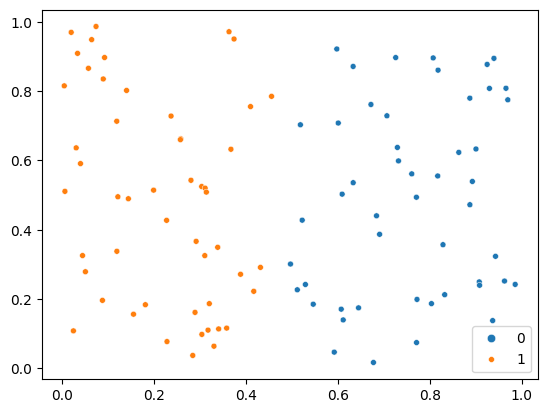

In [2]:
labels_means = []
class Clustering:
    def __init__(self, n_clusters,):
        pass

    def fit(self,X):
        pass

class KMeans(Clustering):
    def __init__(self, n_clusters, max_iter=500):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X, fully_vectorized=False):
        # Randomly initialize cluster centroids
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # Assign each data point to the nearest centroid
            labels = self._assign_labels(X)
            
            # Update cluster centroids
            new_centroids = self._update_centroids(X, labels, fully_vectorized)
            
            # Check for convergence
            if np.allclose(new_centroids, self.centroids):
                break
            
            self.centroids = new_centroids

        return self._assign_labels(X)

                
    def _assign_labels(self, X):
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        # print(distances)
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels, fully_vectorized=False):
        new_centroids = np.empty_like(self.centroids)
        
        if not fully_vectorized:
            for i in range(self.n_clusters):
                new_centroids[i] = np.mean(X[labels == i], axis=0)
        else:
            labels = labels[:,None] == np.arange(self.n_clusters)
            labels = labels.astype(int)
            clusters_amounts = np.sum(labels, axis=0)
            a = X[:,:,None] * labels[:,None,:]
            sum1 = np.sum(a, axis=0)
            mean_of_clusters = sum1/clusters_amounts
            new_centroids = mean_of_clusters.T

        return new_centroids
    
# Example usage
np.random.seed(42)
X = np.random.rand(100, 2)
# X = image_original.reshape(-1,3).copy()

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit(X, fully_vectorized=False)

sns.scatterplot(x=X[:,0],y=X[:,1],hue=labels,size=1)
plt.show()

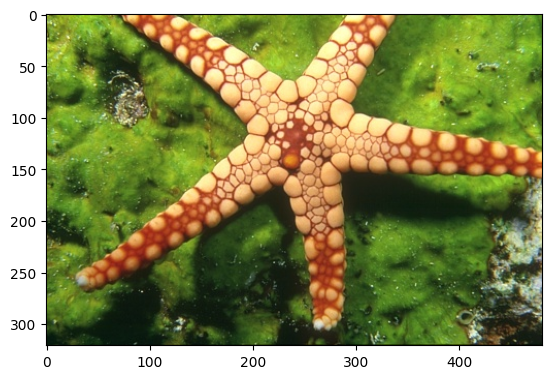

(321, 481, 3)


In [3]:
star_image = cv2.imread("star.jpg")
star_image  = cv2.cvtColor(star_image, cv2.COLOR_BGR2RGB)
plt.imshow(star_image)
plt.show()
print(star_image.shape)

In [4]:
ronto_image = cv2.imread("../4_dimentionality_reduction/ronto_image.jpg")
ronto_image = cv2.cvtColor(ronto_image, cv2.COLOR_BGR2RGB)

In [5]:
def cluster_image(image, num_clusters, clustering_class):
    X = image.reshape(-1,3).copy()
    kmeans = clustering_class(n_clusters=num_clusters)
    labels = kmeans.fit(X.astype(np.float32))
    for i in range(num_clusters):
        X[labels==i] = np.array(kmeans.centroids[i]).astype(np.int32)
    return X.reshape(image.shape)

In [6]:
def clustering_with_pixel_position(image, num_clusters, clustering_class):
    P = image.copy()
    new_shape = image.shape[:2] + (5,)
    new_P = np.zeros(new_shape) # array with (i,j) for each pixel

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_P[i,j] = np.concatenate([P[i,j], np.array([i, j])])

    channel1 = new_P[:,:,3]
    channel2 = new_P[:,:,4]

    # Determine the current min and max values of the additional channels
    old_min1 = np.min(new_P[:,:,3])
    old_max1 = np.max(new_P[:,:,3])
    old_min2 = np.min(new_P[:,:,4])
    old_max2 = np.max(new_P[:,:,4])

    # Map the additional channels to the 0-255 range
    new_min = 0
    new_max = 255

    # Perform linear mapping
    new_channel1 = ((channel1 - old_min1) * (new_max - new_min) / (old_max1 - old_min1)) + new_min
    new_channel2 = ((channel2 - old_min2) * (new_max - new_min) / (old_max2 - old_min2)) + new_min

    # Convert to integers (assuming you want integer values)
    new_P[:,:,3] = new_channel1.astype(int)
    new_P[:,:,4] = new_channel2.astype(int)


    # Need to normalize the channels to distribute the same
        #NORMALIZATION....

    P = new_P.reshape(-1,5).astype(np.float32)
    kmeans =clustering_class(n_clusters=num_clusters)
    labels = kmeans.fit(P)


    for i in range(num_clusters):
        P[labels==i] = np.array(kmeans.centroids[i]).astype(np.int32)

    P = P.reshape(new_shape)
    P = P[:,:,:3].astype(np.int32) # Take only BGR channels
    return P

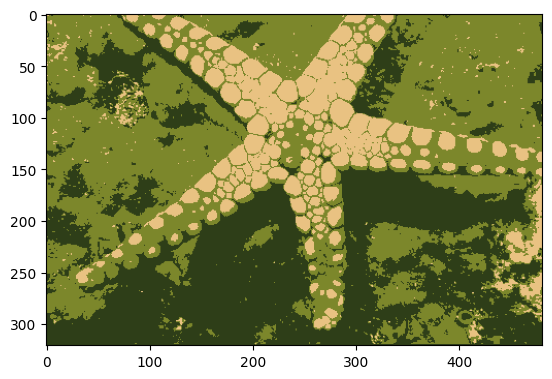

In [7]:
clustered_image = cluster_image(star_image, 3, clustering_class=KMeans)
plt.imshow(clustered_image)

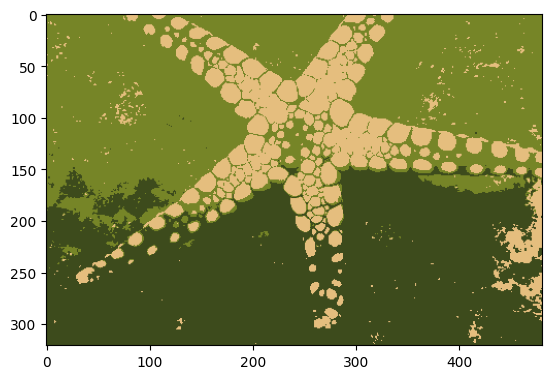

In [8]:
clustered_image = clustering_with_pixel_position(star_image,3, clustering_class=KMeans)
plt.imshow(clustered_image)

##### As we can see, some places the tentacles are cominbing with the background when using pixel distance as well.

In [21]:
import numpy as np

class AgglomerativeClustering:
    def __init__(self, n_clusters=2, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit(self, X):
        # Initialize clusters as singletons
        X = np.array(X)
        # Make sure it is vectors (wrap in list if needed - if it is 1-dimensional)
        if len(X.shape) == 1:
            X = X[:,None]
        
        self.clusters = [[i] for i in range(len(X))]

        while len(self.clusters) > self.n_clusters:
            # distances = self._get_distances(X)
            # min_index = np.unravel_index(np.argmin(distances), distances.shape)
            # i,j = sorted(min_index)

            print("Current number of clusters:", len(self.clusters))

            i,j = sorted(self._get_min_distanced_clusters_indices(X))
            cluster_i = self.clusters[i]
            cluster_j = self.clusters[j]

            # i < j so we can delete like this safely:
            del self.clusters[i]
            del self.clusters[j-1]
            
            self.clusters =  self.clusters + [cluster_i + cluster_j]
        return self._get_labels(X)
    
    def _get_min_distanced_clusters_indices(self,X):
        n = len(self.clusters)
        min_indices = [0,1]
        min_distance = np.inf
        
        shuffled_indices = list(range(n))
        random.shuffle(shuffled_indices)
        for i in range(n):
            cluster_i = X[self.clusters[i]]
            # for j in range(n):
            #     if i != j:
            #         cluster_j = X[self.clusters[j]]
            #         distance = self.compute_distance(cluster_i, cluster_j)
            #         if distance < min_distance:
            #             min_distance = distance
            #             min_indices = [i,j]

            # X[self.cluster]
        return min_indices

            
    # def _get_distances(self,X):
    #     n = len(self.clusters)
    #     distances = np.zeros((n,n))
    #     for i in range(n):
    #         for j in range(n):
    #             if i == j:
    #                 distances[i][j] = np.inf
    #             else:
    #                 cluster_i = X[self.clusters[i]]
    #                 cluster_j = X[self.clusters[j]]
                    
    #                 distances[i][j] = self.compute_distance(cluster_i, cluster_j)

    #     return distances

    def _get_labels(self,X):
        labels = np.zeros(len(X))
        for i, cluster in enumerate(self.clusters):
            labels[cluster] = i
        return labels


    def compute_distance(self, cluster1, cluster2):
        cluster1 = np.array(cluster1)
        cluster2 = np.array(cluster2)
        if self.linkage == 'single':
            return self.single_linkage(cluster1, cluster2)
        elif self.linkage == 'complete':
            return self.complete_linkage(cluster1, cluster2)
        elif self.linkage == 'average':
            return self.average_linkage(cluster1, cluster2)
        else:
            raise ValueError("Linkage type not supported.")

    def single_linkage(self, cluster1, cluster2):
        return np.min(np.linalg.norm(cluster1[:, np.newaxis] - cluster2, axis=2))

    def complete_linkage(self, cluster1, cluster2):
        return np.max(np.linalg.norm(cluster1[:, np.newaxis] - cluster2, axis=2))

    def average_linkage(self, cluster1, cluster2):
        return np.mean(np.linalg.norm(cluster1[:, np.newaxis] - cluster2, axis=2))
    
np.random.seed(200)
X = np.random.rand(100, 2)

# Initialize and fit AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=2)
labels = agglo.fit(X)

print("Cluster labels:", labels)
print("CLUSTERS:",agglo.clusters)

In [22]:
# Example usage:
# Generate some random data
np.random.seed(200)
X = np.random.rand(100, 2)

# Initialize and fit AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=2)
labels = agglo.fit(X)

print("Cluster labels:", labels)
print("CLUSTERS:",agglo.clusters)

Current number of clusters: 100
Current number of clusters: 99
Current number of clusters: 98
Current number of clusters: 97
Current number of clusters: 96
Current number of clusters: 95
Current number of clusters: 94
Current number of clusters: 93
Current number of clusters: 92
Current number of clusters: 91
Current number of clusters: 90
Current number of clusters: 89
Current number of clusters: 88
Current number of clusters: 87
Current number of clusters: 86
Current number of clusters: 85
Current number of clusters: 84
Current number of clusters: 83
Current number of clusters: 82
Current number of clusters: 81
Current number of clusters: 80
Current number of clusters: 79
Current number of clusters: 78
Current number of clusters: 77
Current number of clusters: 76
Current number of clusters: 75
Current number of clusters: 74
Current number of clusters: 73
Current number of clusters: 72
Current number of clusters: 71
Current number of clusters: 70
Current number of clusters: 69
Current

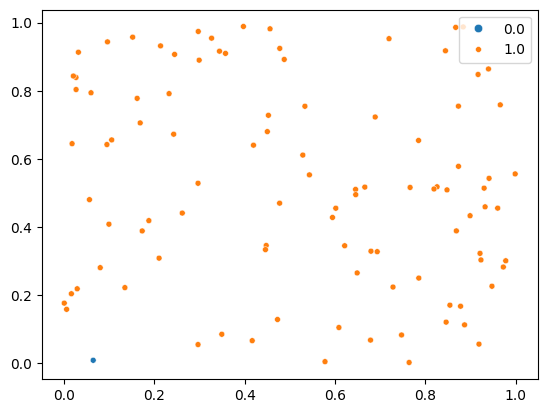

In [107]:
sns.scatterplot(x=X[:,0],y=X[:,1],hue=labels,size=1)
plt.show()

In [121]:
clustered_image = cluster_image(star_image, 3, clustering_class=AgglomerativeClustering)
plt.imshow(clustered_image)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [156], [157], [15

TypeError: 'NoneType' object is not iterable